In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from pyvibdmc.analysis import *
from pyvibdmc.simulation_utilities import *
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def load_training(training_name):
    """If using deb_training_every argument, read the files with this."""
    with h5py.File(training_name, 'r') as f:
        cds = f['coords'][:]
        vs = f['pots'][:]
    return cds, Constants.convert(vs, "wavenumbers", to_AU=False)


def get_ml_data(ts):
    tot_x = []
    tot_v = []
    for time in ts:
        cds, vs = load_training(f"training_water_dt1_1_training_{time}ts.hdf5")
        tot_x.append(cds.squeeze())
        tot_v.append(vs)
    tot_x = np.concatenate(tot_x)
    tot_v = np.concatenate(tot_v)
    return tot_x, tot_v



def pre_process(x):
    
    X_MIN = 0
    X_MAX = 5
    
    def dis_map(coord):
        dis_generator = lambda i,j: np.linalg.norm(coord[i]-coord[j])
        full_map = np.fromfunction(np.vectorize(dis_generator), (3,3), dtype=int)
        return np.triu(full_map)

    def normalize(x):
        return (x-X_MIN)/(X_MAX-X_MIN)

#     def padding(x):
#         return np.pad(x, ((1,1),(1,1)))

    x = np.array([[dis_map(cd)] for cd in x])
    return normalize(x)


tss = [100, 200, 300, 400, 500]
tss = [100, 200]
train_x, train_y = get_ml_data(tss)
train_x = pre_process(train_x)

val_set = [800]
val_x, val_y = get_ml_data(val_set)
val_x = pre_process(val_x)

In [4]:
train_x.shape

(20001, 1, 3, 3)

In [81]:
model = models.Sequential()
model.add(layers.Conv2D(4, (2,2), activation=tf.nn.swish, 
                        input_shape=(1,3,3), data_format='channels_first', padding='same'))
model.add(layers.Conv2D(4, (3,3), activation=tf.nn.swish, data_format='channels_first'))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation=tf.nn.swish))
model.add(layers.Dense(16, activation=tf.nn.swish))
model.add(layers.Dense(16, activation=tf.nn.swish))
model.add(layers.Dense(1, activation='linear'))

model.summary()

model.load_weights('cnn_weights_h2o.h5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 4, 3, 3)           20        
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 4, 1, 1)           148       
_________________________________________________________________
flatten_5 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                80        
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                

In [82]:
#lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(0.005, decay_steps=100000, decay_rate=0.8)
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.00001)

model.compile(optimizer=optimizer,
                 loss='mse',
                 metrics=[])

In [72]:
history = model.fit(train_x, train_y, validation_split=0.1, batch_size=64, epochs=100)

Epoch 1/100
282/282 [==============================] - 2s 6ms/step - loss: 84.7174 - val_loss: 45.4328
Epoch 2/100
282/282 [==============================] - 2s 8ms/step - loss: 83.5976 - val_loss: 34.6228
Epoch 3/100
282/282 [==============================] - 2s 8ms/step - loss: 84.4655 - val_loss: 50.3819
Epoch 4/100
282/282 [==============================] - 3s 10ms/step - loss: 82.7196 - val_loss: 92.0229
Epoch 5/100
282/282 [==============================] - 2s 8ms/step - loss: 83.1904 - val_loss: 33.6408
Epoch 6/100
282/282 [==============================] - 2s 6ms/step - loss: 82.3377 - val_loss: 30.4162
Epoch 7/100
282/282 [==============================] - 3s 10ms/step - loss: 82.8847 - val_loss: 40.6500
Epoch 8/100
282/282 [==============================] - 1s 5ms/step - loss: 81.8416 - val_loss: 28.6113
Epoch 9/100
282/282 [==============================] - 1s 4ms/step - loss: 81.9122 - val_loss: 29.3942
Epoch 10/100
282/282 [==============================] - 2s 6ms/step - l

Epoch 80/100
282/282 [==============================] - 2s 6ms/step - loss: 79.7678 - val_loss: 33.0571
Epoch 81/100
282/282 [==============================] - 2s 7ms/step - loss: 80.2224 - val_loss: 30.8669
Epoch 82/100
282/282 [==============================] - 3s 10ms/step - loss: 80.7519 - val_loss: 38.5377
Epoch 83/100
282/282 [==============================] - 3s 11ms/step - loss: 80.3781 - val_loss: 29.3462
Epoch 84/100
282/282 [==============================] - 2s 7ms/step - loss: 79.8994 - val_loss: 28.7241
Epoch 85/100
282/282 [==============================] - 2s 7ms/step - loss: 80.4180 - val_loss: 33.8534
Epoch 86/100
282/282 [==============================] - 2s 9ms/step - loss: 80.4597 - val_loss: 34.0982
Epoch 87/100
282/282 [==============================] - 1s 3ms/step - loss: 80.5766 - val_loss: 29.5922
Epoch 88/100
282/282 [==============================] - 2s 6ms/step - loss: 80.2715 - val_loss: 31.5700
Epoch 89/100
282/282 [==============================] - 1s 5ms

In [73]:
def plot_result(val_x, val_y, history, model):
    fig = plt.figure(figsize=(8,6))
    ax_loss = fig.add_subplot(111)
#    ax_data = fig.add_subplot(212)
    
    ax_loss.plot(history.history['loss'])
    ax_loss.plot(history.history['val_loss'])
    ax_loss.set_ylabel('loss')
    ax_loss.set_xlabel('epoch')
    ax_loss.legend(['train', 'test'], loc='upper right')
    
#     ax_data.scatter(val_x,val_y)
#     ax_data.scatter(val_x, model.predict(val_x), marker='|')
#     ax_data.legend(['Analytic', 'Predicted'], loc='upper right')
    
    plt.show()

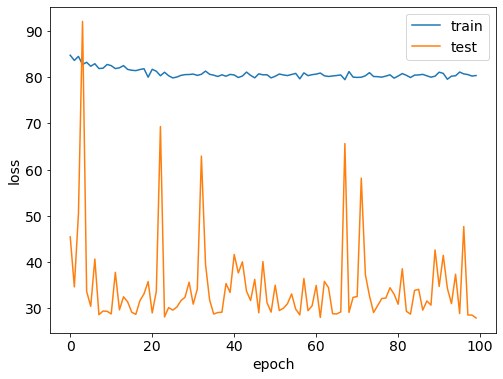

In [74]:
plot_result(val_x, val_y, history, model)

In [75]:
model.save_weights('cnn_weights_h2o.h5')

In [83]:
print("       Label        Predicted")
val_data = np.concatenate((np.expand_dims(val_y, axis=1), model.predict(val_x)),axis=1)
print(val_data[:10])

       Label        Predicted
[[ 5049.68186109  5047.63427734]
 [  717.14191168   722.82531738]
 [ 5966.28704558  5966.41748047]
 [  598.95307243   599.08374023]
 [15837.89958316 15855.75292969]
 [  287.54386184   287.43081665]
 [11034.94825861 11046.65429688]
 [ 4276.68022732  4262.18310547]
 [ 3409.25650976  3402.41967773]
 [ 3664.63140549  3657.90039062]]


(-0.001, 0.03)

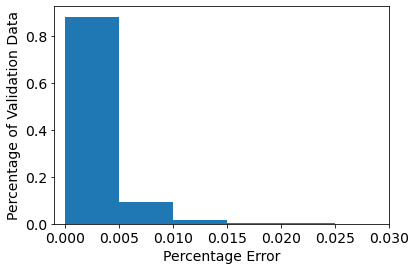

In [89]:
weights = np.ones_like(val_data[:,0]) / len(val_data[:,0])
plt.hist(np.abs(val_data[:,0]-val_data[:,1])/val_data[:,0], bins=np.arange(0,1,0.005), weights=weights)
plt.xlabel('Percentage Error')
plt.ylabel('Percentage of Validation Data')
plt.xlim((-0.001,0.03))

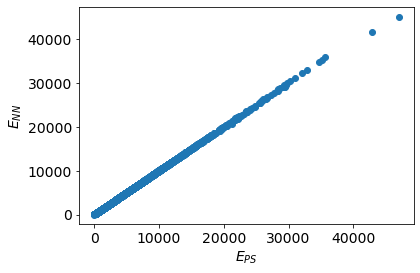

In [85]:
plt.scatter(val_data[:,0], val_data[:,1])
plt.xlabel('$E_{PS}$')
plt.ylabel('$E_{NN}$')
plt.show()

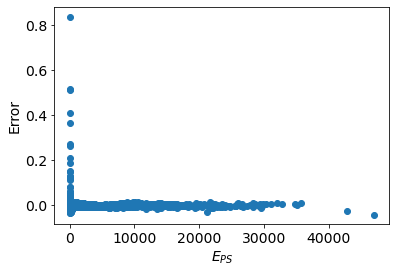

In [86]:
plt.scatter(val_data[:,0], (val_data[:,1]-val_data[:,0])/val_data[:,1])
plt.xlabel('$E_{PS}$')
plt.ylabel('Error')
plt.show()